# ZEMAX Rayfile Generation

['100dc.txt', 'FF CW Row 1&2_0001.ascii.csv', 'FF CW Row 3&4_0001.ascii.csv', 'NF CW Row 1&2_0001.ascii.csv', 'NF CW Row 3&4_0001.ascii.csv']


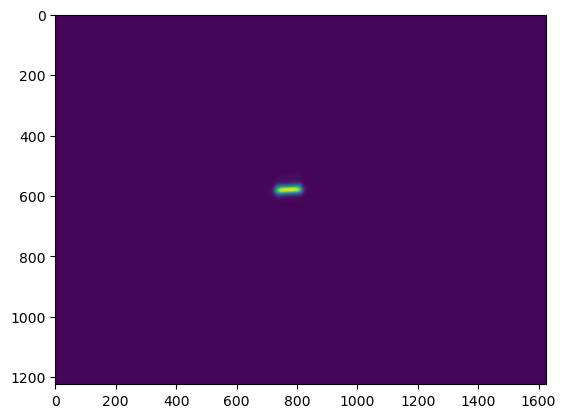

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create a list of the files
folder = r'../tests/test_beam_profiles/For_Rayfile_Gen/22'
print(os.listdir(folder))

# Far field images
ff1_file = '/'.join([folder,r'FF CW Row 1&2_0001.ascii.csv'])
ff2_file = '/'.join([folder,r'FF CW Row 3&4_0001.ascii.csv'])

# Near field images
nf1_file = '/'.join([folder,r'NF CW Row 1&2_0001.ascii.csv'])
nf2_file = '/'.join([folder,r'NF CW Row 3&4_0001.ascii.csv'])

# Spectrum
spectrum_file = '/'.join([folder, r'100dc.txt'])

# Read spectrum method
def open_spectrum(file_name):
    x = []
    y = []
    with open(file_name,"r") as file:
        data=file.read()
        dataList = data.split('\n')
        for i in range(1,len(dataList)-1):
            temp = dataList[i].split('\t')
            x.append(float(temp[0]))
            y.append(float(temp[1]))
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

# Parse ASCII File
def parseAscii(filename):
    slens = []
    A = []
    with open(filename) as f:
        for rows in f:
            s = rows.split(',')
            slens.append(len(s))
        maxlen = max(slens)    
    with open(filename) as f:
        for rows in f:
            s1 = rows.strip('\n')
            s = s1.split(',')
            for i in range(0,maxlen):
                if (i >= len(s)):
                    s.append(0.0)
                elif (s[i] == ''):
                    s[i] = 0.0
                else:
                    s[i] = float(s[i])
                i = i+1
            A.append(s)
    B = np.array(A)
    return B

# generate lists
spec_x, spec_y = open_spectrum(spectrum_file)

# Trim spectrum file
indexs = (spec_x < 460) & (spec_x > 430)
spec_x_t = spec_x[indexs]
spec_y_t = spec_y[indexs]

# Generate Near Field Arrays
nf1 = parseAscii(nf1_file)
nf2 = parseAscii(nf2_file)

# Averaged image
nf = ((nf1/np.sum(nf1)) + (nf2/np.sum(nf2))) * 0.5

# Generate Far Field Arrays
ff1 = parseAscii(ff1_file)
ff2 = parseAscii(ff2_file)

# Averaged image
ff = ((ff1/np.sum(ff1)) + (ff2/np.sum(ff2))) * 0.5

plt.imshow(ff)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(title, fontsize=30)

plt.plot(spec_x,spec_y)